<a href="https://colab.research.google.com/github/siddharthc30/Malaria_detect/blob/main/Malaria_Detect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files
upload = files.upload()

Saving kaggle.json to kaggle.json


In [8]:
!cp kaggle.json /root/.kaggle

In [9]:
!ls

kaggle.json  sample_data


In [10]:
!chmod 600 /root/.kaggle/kaggle.json

In [11]:
! kaggle datasets download -d iarunava/cell-images-for-detecting-malaria

 99% 667M/675M [00:14<00:00, 53.7MB/s]
100% 675M/675M [00:14<00:00, 48.5MB/s]


In [12]:
from zipfile import ZipFile
with ZipFile('cell-images-for-detecting-malaria.zip','r') as zip:
  zip.extractall()

In [13]:
import os

dir = '/content/cell_images/cell_images'
print(os.listdir(dir))

['Parasitized', 'Uninfected']


In [26]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torchvision
import torchvision.models as models
from torchvision import datasets, transforms
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F

In [16]:
train_transforms = transforms.Compose([transforms.Resize((120, 120)),
                                       transforms.ColorJitter(0.05),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomVerticalFlip(),
                                       transforms.RandomRotation(20),
                                       transforms.ToTensor(), 
                                       transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
                                     ])

train_set = datasets.ImageFolder(dir, transform = train_transforms)

In [18]:
test_size = 0.25
num_train = len(train_set)
indices = list(range(num_train))
np.random.shuffle(indices)

test_split = int(np.floor((test_size)*num_train))
train_index, test_index = indices[test_split - 1 :], indices[: test_split - 1]

train_sampler = SubsetRandomSampler(train_index)
test_sampler = SubsetRandomSampler(test_index)

train_loader = DataLoader(train_set, sampler=train_sampler, batch_size=104)
test_loader = DataLoader(train_set, sampler=test_sampler, batch_size=58)

print("Images in Test set: {}\nImages in Train set: {}".format(len(test_index), len(train_index)))               

Images in Test set: 6888
Images in Train set: 20670


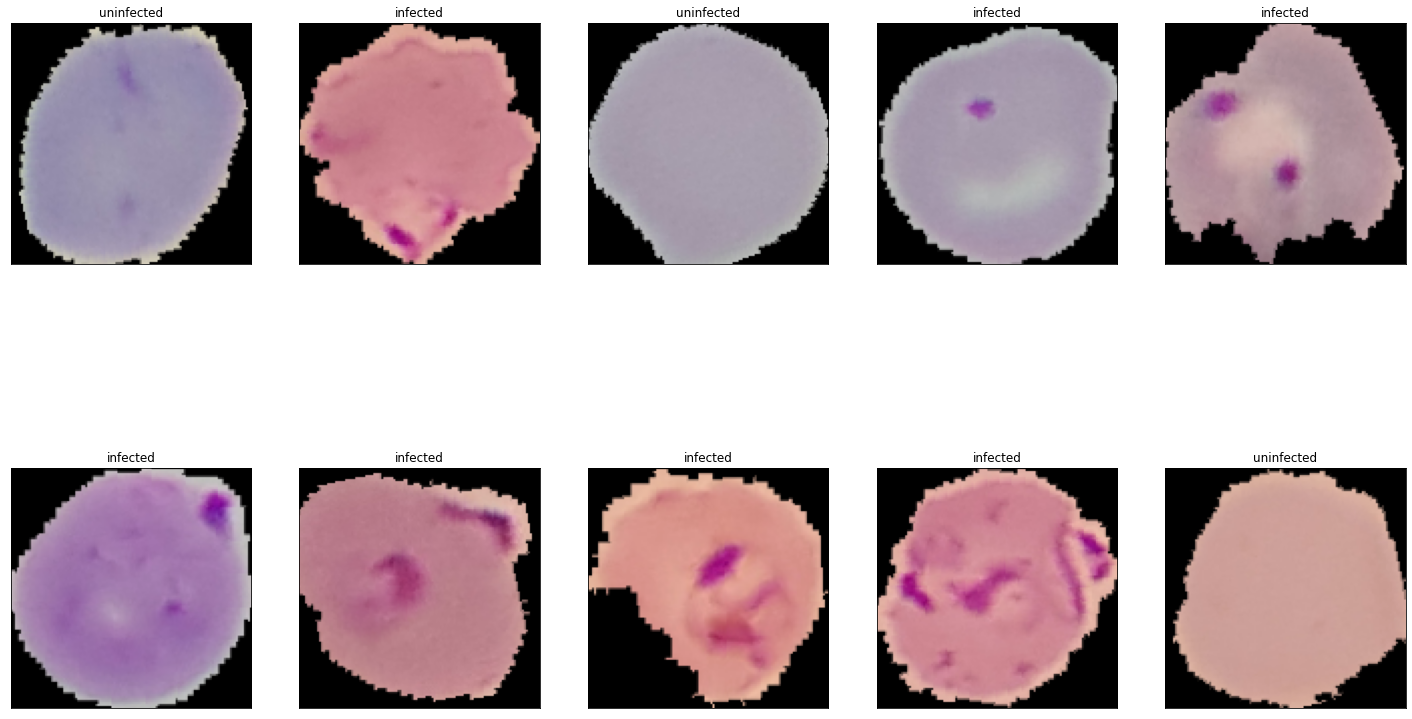

In [19]:
classes=['infected','uninfected']
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
images, labels = next(iter(train_loader))

fig = plt.figure(figsize=(25, 15))

for i in range(10):
    ax = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[], title=classes[labels[i]])
    imshow(images[i])
plt.show()

In [21]:
model = models.resnet34(pretrained = True)
num_features_last = model.fc.in_features
model.fc = nn.Linear(num_features_last, 2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [22]:
error = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [23]:
num_epochs = 30
batch_size = 100 

for epoch in range(num_epochs):
    train_loss = 0.
    model.train()    # explictily stating the training
    
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        train = images.view(-1, 3, 120, 120)
        outputs = model(train)
        
        optimizer.zero_grad()
        loss = error(outputs, labels)
        loss.backward()    #back-propagation
        optimizer.step()
        
        train_loss += loss.item() * batch_size
     
    print("Epoch: {}, Loss: {:.4f}".format(epoch + 1, train_loss / len(train_loader.dataset)))


Epoch: 1, Loss: 0.1152
Epoch: 2, Loss: 0.0823
Epoch: 3, Loss: 0.0756
Epoch: 4, Loss: 0.0731
Epoch: 5, Loss: 0.0667
Epoch: 6, Loss: 0.0679
Epoch: 7, Loss: 0.0646
Epoch: 8, Loss: 0.0654
Epoch: 9, Loss: 0.0622
Epoch: 10, Loss: 0.0620
Epoch: 11, Loss: 0.0582
Epoch: 12, Loss: 0.0588
Epoch: 13, Loss: 0.0576
Epoch: 14, Loss: 0.0566
Epoch: 15, Loss: 0.0556
Epoch: 16, Loss: 0.0528
Epoch: 17, Loss: 0.0526
Epoch: 18, Loss: 0.0538
Epoch: 19, Loss: 0.0553
Epoch: 20, Loss: 0.0544
Epoch: 21, Loss: 0.0499
Epoch: 22, Loss: 0.0496
Epoch: 23, Loss: 0.0475
Epoch: 24, Loss: 0.0474
Epoch: 25, Loss: 0.0478
Epoch: 26, Loss: 0.0457
Epoch: 27, Loss: 0.0446
Epoch: 28, Loss: 0.0482
Epoch: 29, Loss: 0.0438
Epoch: 30, Loss: 0.0434


In [24]:
correct = 0
total = 0
class_total = [0 for _ in range(2)]
class_correct = [0 for _ in range(2)]
batch_size = 20
# Lists used in Confusion Matrix
actual = []
predict = []

model.eval()    # explicitly stating the testing 
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to (device)
        
        actual.append(labels.data.tolist())
        test = images.view(-1, 3, 120, 120)
        outputs = model(test)
        predicted = torch.max(outputs, 1)[1]
        predict.append(predicted.data.tolist())
        total += len(labels)
        correct += (predicted == labels).sum().item()
        # Calculating classwise accuracy
        c = (predicted == labels).squeeze()
        for i in range(batch_size):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
        
print("Accuracy on the Test set: {:.2f}%".format(correct * 100 / total))
print()
for i in range(2):
    print("Accuracy of {} :  {:.2f}%   [{} / {}]".format(classes[i], class_correct[i] * 100 / class_total[i], 
                                           class_correct[i], class_total[i]))

Accuracy on the Test set: 97.14%

Accuracy of infected :  97.53%   [1185 / 1215]
Accuracy of uninfected :  97.00%   [1130 / 1165]


In [1]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import itertools

#flatten out 2D list into 1D
actual = list(itertools.chain.from_iterable(actual))
predict = list(itertools.chain.from_iterable(predict))
results = confusion_matrix(actual, predict)
print("Accuracy Score: ")
print("{:.4f}".format(accuracy_score(actual, predict)))
print()
print("Report: ")
print(classification_report(actual, predict))
print()
print("Confusion Matrix: ")
print(pd.DataFrame(results, columns=["Predicted No", "Predicted Yes"], index=["Actual No", "Actual Yes"]))


NameError: ignored